# Python Tutorial - How to work with CoastWatch data in Python

This tutorial will show the following using satellite water temperature data for Lake Erie:
* The steps to grab satellite data from ERDDAP using Python
* How to work with NetCDF files in Python 
* How to make some maps of satellite data
* How to generate time-series of satellite data and plot it
* How to create a monthly average map from daily satellite data



## 1. Downlading data from Python

Because ERDDAP includes RESTful services, you can download data listed on any ERDDAP platform from Python using the URL structure. For example, the following page allows you to subset daily water surface temperature data from the dataset GLSEA_GCS

![](gl_erddap.png)

In this specific example, the URL we generated for the NetCDF file is :

https://coastwatch.glerl.noaa.gov/erddap/griddap/GLSEA_GCS.nc?sst[(2021-06-01T12:00:00Z):1:(2021-06-30T12:00:00Z)][(41):1:(43)][(-83.5):1:(-78.5)]


In Python, run the following to download the data using the generated URL :


In [104]:
import urllib3
import certifi

url = ("https://coastwatch.glerl.noaa.gov/erddap/griddap/GLSEA_GCS.nc?"+
       "sst[(2021-06-01T12:00:00Z):1:(2021-06-30T12:00:00Z)][(41):1:(43)][(-83.5):1:(-78.5)]")

http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
r = http.request('GET', url, preload_content=False)
with open("e_sst.nc", "wb") as out:
    while True:
        data = r.read(1024*1024)
        if not data:
            break
        out.write(data)
r.release_conn()


# 2. Importing NetCDF4 data in Python

Now that we've downloaded the data locally, we can import it and extract our variables of interest.

The xarray package makes it very convenient to work with NetCDF files. Documentation is available here:
http://xarray.pydata.org/en/stable/why-xarray.html

* Import the xarray and netCDF4 packages
* Load the downloaded data file in as an xarray dataset
* Render the dataset in the Jupyter Notebook to easily get familiar with the dataset

In [105]:
import xarray as xr
import netCDF4 as nc

ds = xr.open_dataset('e_sst.nc',decode_cf=False)
ds

<xarray.Dataset>
Dimensions:    (latitude: 143, longitude: 358, time: 30)
Coordinates:
  * time       (time) float64 1.623e+09 1.623e+09 ... 1.625e+09 1.625e+09
  * latitude   (latitude) float64 41.01 41.02 41.03 41.05 ... 42.97 42.98 43.0
  * longitude  (longitude) float64 -83.51 -83.49 -83.48 ... -78.53 -78.52 -78.5
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes: (12/28)
    cdm_data_type:              Grid
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    Easternmost_Easting:        -78.5025420282563
    GDAL:                       GDAL 2.1.3, released 2017/20/01
    geospatial_lat_max:         42.9955492889388
    geospatial_lat_min:         41.0053458284672
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table v29
    summary:                    Sea Surface Temperature (SST) from Great Lake...
    time_coverage_end:          2021-06-30T12:00:00Z
    time_coverage_start:        2021-06-01T12:00:00Z
    title:                      Sea Surface Temperature (SST) from Great Lake...
    Westernmost_Easting:        -83.5060817140899

###  Examine the coordinates and variables included in the dataset
As mentioned, you can easily view the information about the data set that is stored in the NetCDF file. In the previous step we used the Jupyter Notebook diplay of the dataset. Here are functions that provide the same information with callable commands including how to:

* List the coordinates and variables using the `coords` and `data_vars` commands
* View the metadata attributes using the `attrs` command
* Get the structure of the SST variable using the `shape` command 

We can see our coordinates are `time`, `latitude` and `longitude` and our data variables are `sst`. We can also see that the SST data is a 3-D array with 30 time steps, 143 rows and 358 columns. From the metadata we can see that the rows and columns correspond to latatude and longitude.

In [113]:
print(ds.coords)
print(ds.data_vars)
print(ds.sst.shape)

Coordinates:
  * time       (time) float64 1.623e+09 1.623e+09 ... 1.625e+09 1.625e+09
  * latitude   (latitude) float64 41.01 41.02 41.03 41.05 ... 42.97 42.98 43.0
  * longitude  (longitude) float64 -83.51 -83.49 -83.48 ... -78.53 -78.52 -78.5
Data variables:
    sst      (time, latitude, longitude) float32 ...
(30, 143, 358)


In [111]:
print(ds.attrs)

{'cdm_data_type': 'Grid', 'Conventions': 'CF-1.6, COARDS, ACDD-1.3', 'Easternmost_Easting': -78.5025420282563, 'GDAL': 'GDAL 2.1.3, released 2017/20/01', 'geospatial_lat_max': 42.9955492889388, 'geospatial_lat_min': 41.0053458284672, 'geospatial_lat_resolution': 0.014015517327264998, 'geospatial_lat_units': 'degrees_north', 'geospatial_lon_max': -78.5025420282563, 'geospatial_lon_min': -83.5060817140899, 'geospatial_lon_resolution': 0.014015517327265001, 'geospatial_lon_units': 'degrees_east', 'history': 'Sea Surface Temperature (SST) from Great Lakes Surface Environmental Analysis (GLSEA) asc format to nc fromat\n2021-07-26T21:11:59Z (local files)\n2021-07-26T21:11:59Z http://coastwatch.glerl.noaa.gov/erddap/griddap/GLSEA_GCS.nc?sst%5B(2021-06-01T12:00:00Z):1:(2021-06-30T12:00:00Z)%5D%5B(41):1:(43)%5D%5B(-83.5):1:(-78.5)%5D', 'infoUrl': 'https://coastwatch.glerl.noaa.gov/glsea/glsea.html', 'institution': 'CoastWatch Great Lakes Node', 'keywords': 'analysis, data, earth, Earth Science 

### Examine the time steps in the data file
View the time variable and its attributes. We can see that the time variable in this file uses the standard units of `seconds since 1970-01-01T00:00:00Z`. 



In [87]:
ds.time

<xarray.DataArray 'time' (time: 30)>
array([1.622549e+09, 1.622635e+09, 1.622722e+09, 1.622808e+09, 1.622894e+09,
       1.622981e+09, 1.623067e+09, 1.623154e+09, 1.623240e+09, 1.623326e+09,
       1.623413e+09, 1.623499e+09, 1.623586e+09, 1.623672e+09, 1.623758e+09,
       1.623845e+09, 1.623931e+09, 1.624018e+09, 1.624104e+09, 1.624190e+09,
       1.624277e+09, 1.624363e+09, 1.624450e+09, 1.624536e+09, 1.624622e+09,
       1.624709e+09, 1.624795e+09, 1.624882e+09, 1.624968e+09, 1.625054e+09])
Coordinates:
  * time     (time) float64 1.623e+09 1.623e+09 ... 1.625e+09 1.625e+09
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [1.6225488e+09 1.6250544e+09]
    axis:                 T
    calendar:             Gregorian
    ioos_category:        Time
    long_name:            Easten Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00
    units:                seconds since 1970-01-01T00:00:00Z

In [88]:
ds.time.attrs

{'_CoordinateAxisType': 'Time',
 'actual_range': array([1.6225488e+09, 1.6250544e+09]),
 'axis': 'T',
 'calendar': 'Gregorian',
 'ioos_category': 'Time',
 'long_name': 'Easten Time',
 'standard_name': 'time',
 'time_origin': '01-JAN-1970 00:00:00',
 'units': 'seconds since 1970-01-01T00:00:00Z'}

## Working with the extracted data

### Create a datetime object for date handling in Python
Here we will convert the dates to a `datetime` object for manipulation in Python.
* Create a `datetime` object using the __netCDF4__ function __num2date__
* The datetime object includes year, month, hour, minutes, eg. 2021, 6, 12, 0

In [89]:
dates = nc.num2date(ds.time,ds.time.units,only_use_cftime_datetimes=False, 
                        only_use_python_datetimes=True )
dates

array([datetime.datetime(2021, 6, 1, 12, 0),
       datetime.datetime(2021, 6, 2, 12, 0),
       datetime.datetime(2021, 6, 3, 12, 0),
       datetime.datetime(2021, 6, 4, 12, 0),
       datetime.datetime(2021, 6, 5, 12, 0),
       datetime.datetime(2021, 6, 6, 12, 0),
       datetime.datetime(2021, 6, 7, 12, 0),
       datetime.datetime(2021, 6, 8, 12, 0),
       datetime.datetime(2021, 6, 9, 12, 0),
       datetime.datetime(2021, 6, 10, 12, 0),
       datetime.datetime(2021, 6, 11, 12, 0),
       datetime.datetime(2021, 6, 12, 12, 0),
       datetime.datetime(2021, 6, 13, 12, 0),
       datetime.datetime(2021, 6, 14, 12, 0),
       datetime.datetime(2021, 6, 15, 12, 0),
       datetime.datetime(2021, 6, 16, 12, 0),
       datetime.datetime(2021, 6, 17, 12, 0),
       datetime.datetime(2021, 6, 18, 12, 0),
       datetime.datetime(2021, 6, 19, 12, 0),
       datetime.datetime(2021, 6, 20, 12, 0),
       datetime.datetime(2021, 6, 21, 12, 0),
       datetime.datetime(2021, 6, 22, 12, 0

### Create a map of SST
* Let's create a map of SST for June 1, 2021 (our first time step). 
* We will import pandas and numpy for data handling, and a subset of matplotlib to generate the plot 
* We will take a closer look at the data in the SST variable
* Make adjustments needed for plotting the data

In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
np.warnings.filterwarnings('ignore')

In [91]:
ds.sst.values

array([[[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        ...,
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.]],

       [[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        ...,
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.]],

       [[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
    

In [92]:
ds.sst.attrs

{'_FillValue': -99999.0,
 'colorBarMaximum': 32.0,
 'colorBarMinimum': 0.0,
 'grid_mapping': 'crs',
 'ioos_category': 'Temperature',
 'long_name': 'Temperature',
 'standard_name': 'sea_water_temperature',
 'units': 'degree_C'}

In [93]:
ds.sst.attrs['_FillValue']

-99999.0

* Create a new array where the **_FillValue** is replaced with __nan__
* You can now easily see the range of the sst data  
* Find minimum and maximum sst values using the new __nan_sst__ variable

In [94]:
nan_sst = ds.sst.where(ds.sst.values != ds.sst.attrs['_FillValue'])

print(np.nanmin(ds.sst))
print(np.nanmin(nan_sst))
print(np.nanmax(nan_sst))

-99999.0
9.78
26.39


### Set up our map color scale
Now that we know the water temperature range for this time step, we can set up our plot color scale. 
* Use the min and max values to create a list of levels
* Define a custom palette that we will name __jet__ 
* More info on custom color palette and color maps: https://www.youtube.com/watch?v=qk0n-YaKIkY
* Define the SST ranges we want to coordinate to each color in the palette

In [95]:
levs = np.arange(9.78, 26.39, 0.05)
len(levs)

333

In [96]:
# Define a color palette with a color list
jet = ["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]

# Set color scale using the jet palette
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

### Make a Map of  Lake Erie Water Surface Temperature
* Use contourf to create a filled contour plot of the satellite temperature data
* To demonstrate plotting station locations on the map we will create an array of marker points along 42 deg North Latitude

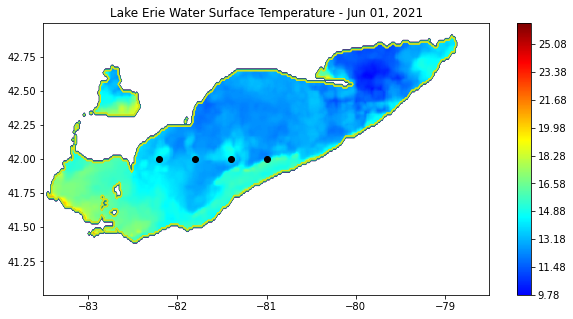

In [97]:
plt.subplots(figsize=(10, 5))

# Plot SST data for the first time stamp 
plt.contourf(
    nan_sst.longitude, 
    nan_sst.latitude, 
    nan_sst[0,:,:], 
    levs, 
    cmap=cm
)

# Add the color scale to the plot
plt.colorbar()

# Add marker points to the map
map_points = np.linspace(-82.2,-81, num=4)
plt.scatter(
    map_points,
    np.repeat(42,4),
    c = 'black'
)

# Add a contour line
plt.contour(
    ds.longitude, 
    ds.latitude, 
    ds.sst[0,:,:], 
    levels=20, 
    linewidths=1
)

# Add a plot title and show the map plot
plt.title("Lake Erie Water Surface Temperature - " + dates[0].strftime('%b %d, %Y'))
plt.show()

### PLOTTING A TIME-SERIES OF SATELLITE DATA

Select a region of interest and extract a time-series of the satellite data within that box.

* Subset the region by selecting a slice of the data based on a coordinates box
* For a region on the west side of the lake, use the following box: 41.75-42.0N, 83.0-83.5W. 


In [98]:
lat_bnds, lon_bnds = [41.75, 42.0], [-83.5, -83.0]
a_sst = nan_sst.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
print(a_sst)

<xarray.DataArray 'sst' (time: 30, latitude: 17, longitude: 36)>
array([[[  nan,   nan,   nan, ..., 16.52, 16.41, 16.41],
        [  nan,   nan,   nan, ..., 16.48, 16.35, 16.35],
        [  nan,   nan,   nan, ..., 16.43, 16.32, 16.32],
        ...,
        [  nan,   nan,   nan, ..., 15.75, 15.91, 15.91],
        [  nan,   nan,   nan, ..., 15.65, 15.77, 15.77],
        [  nan,   nan,   nan, ..., 15.68, 15.73, 15.73]],

       [[  nan,   nan,   nan, ..., 16.53, 16.43, 16.43],
        [  nan,   nan,   nan, ..., 16.47, 16.35, 16.35],
        [  nan,   nan,   nan, ..., 16.4 , 16.3 , 16.3 ],
        ...,
        [  nan,   nan,   nan, ..., 16.51, 16.5 , 16.5 ],
        [  nan,   nan,   nan, ..., 16.37, 16.26, 16.26],
        [  nan,   nan,   nan, ..., 16.3 , 16.09, 16.09]],

       [[  nan,   nan,   nan, ..., 16.58, 16.49, 16.49],
        [  nan,   nan,   nan, ..., 16.5 , 16.39, 16.39],
        [  nan,   nan,   nan, ..., 16.42, 16.32, 16.32],
        ...,
...
        ...,
        [  nan,   na

__Show a quick map of the subsetted area__

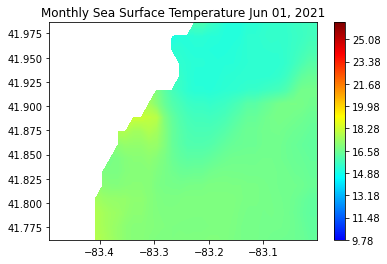

In [99]:
# Plot the first time stamp of the sst array
plt.contourf(a_sst.longitude, a_sst.latitude, a_sst[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %d, %Y'))
plt.show()

__Compute the daily mean over the subset region__

In [100]:
region_sst = np.nanmean(a_sst,axis=(1,2))
region_sst


array([16.40967 , 16.738895, 16.773458, 17.019152, 18.10647 , 19.264048,
       19.384449, 19.623386, 22.149694, 22.733553, 22.451645, 22.50132 ,
       23.450518, 23.508892, 22.962822, 22.560635, 22.52647 , 22.522024,
       22.526493, 22.916142, 22.866966, 22.473318, 22.333248, 22.242752,
       22.28167 , 22.3096  , 22.608166, 22.80767 , 24.325294, 24.401577],
      dtype=float32)

__Make the Time-Series Plot__

Generate a time series plot of the daily mean water temperature within the selected subset region for the month of June.

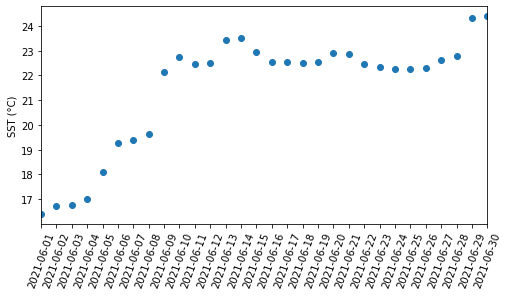

In [101]:
plt.figure(figsize = (8,4))
plt.scatter(dates, region_sst)
plt.ylabel('SST (' + u"\N{DEGREE SIGN}" + 'C)')
plt.xlim(dates[0], dates[-1])
plt.xticks(dates, rotation=70, fontsize=10);


### MAKE A MAP OF MONTHLY AVERAGE SST

We have been looking at daily water temperature in Lake Erie, next let's look at the average water temperature for the month of June 2021.
* Create an average of the data in the __nan_sst__ variable
* Plot the monthly mean using the same axes and colorbar specified for our previous plot

(143, 358)


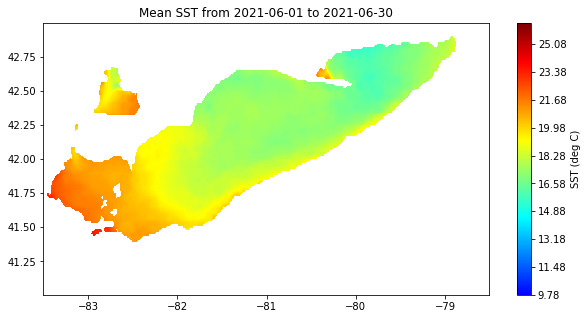

In [102]:
mean_sst = np.nanmean(nan_sst,axis=0)
print(mean_sst.shape)

plt.subplots(figsize=(10, 5))

plt.contourf(ds.longitude, ds.latitude, mean_sst, levs,cmap=cm)

cbar = plt.colorbar()
cbar.set_label('SST (deg C)')

plt.title("Mean SST from " + dates[0].strftime('%Y-%m-%d')+' to '+dates[-1].strftime('%Y-%m-%d'))
plt.show()

### References
This tutorial is based on the OceanWatch tutorial material edited with Great Lakes data. 